In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from itertools import product
from pygam import PoissonGAM, LinearGAM, s, te
import math

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from itertools import product
from pygam import PoissonGAM, LinearGAM, s, te
import math


class CountData:
    """
    Encapsulates loading and preparing count data, with convenience methods
    to filter by species and compute per-day aggregates.

    Attributes
    ----------
    all_count : pandas.DataFrame
        Raw observations filtered by years and doy, with 'doy' and 'year' columns.
    all_count_sp : pandas.DataFrame
        Unique observation periods (without species, count) with computed 'duration' (hours).
    """

    # Default species list from the training commands
    DEFAULT_SPECIES = [
        "Common Buzzard",
        "Red Kite",
        "Black Kite",
        "European Honey-buzzard",
        "Western Marsh Harrier",
        "Eurasian Sparrowhawk",
        "Eurasian Kestrel",
        "Osprey",
        "Hen Harrier",
        "Merlin",
        "Eurasian Hobby",
    ]

    def __init__(self, data_dir="../data", years=range(1966, 2030), doy=[196, 335]):
        self.data_dir = data_dir
        self.years = years
        self.doy = doy

        # Read the count data
        self.all_count = pd.read_csv(
            f"{self.data_dir}/count/all_count_processed.csv",
            parse_dates=["date", "start", "end"],
        )

        # Add derived columns
        self.all_count["doy"] = self.all_count["date"].dt.day_of_year
        self.all_count["year"] = self.all_count["date"].dt.year

        # Filter data by years and day of year
        self.all_count = self.all_count[
            self.all_count["date"].dt.year.isin(self.years)
            & self.all_count["date"].dt.day_of_year.between(self.doy[0], self.doy[1])
        ]

        # Build dataframe with all periods (regardless of species)
        self.all_count_sp = self.all_count[
            [x for x in list(self.all_count) if x not in ["species", "count"]]
        ].drop_duplicates()

        # Pre-compute duration for all periods (in hours)
        self.all_count_sp["duration"] = (
            self.all_count_sp["end"] - self.all_count_sp["start"]
        ).dt.total_seconds() / 3600

        # Load taxonomy to map English name -> trektellen_species_id
        # Ensure IDs are exported as integers (not floats) when present.
        # Columns expected: 'English name', 'trektellen_species_id'
        taxonomy = pd.read_csv("../data/taxonomy.csv")

        # Coerce to numeric (in case of empty strings) then drop NaN when building mapping
        taxonomy["trektellen_species_id"] = pd.to_numeric(
            taxonomy["trektellen_species_id"], errors="coerce"
        )

        # Build mapping: English name -> int ID (only if not NaN)
        name_to_id = {}
        for eng_name, val in taxonomy[
            ["English name", "trektellen_species_id"]
        ].itertuples(index=False):
            if not (isinstance(val, float) and math.isnan(val)):
                name_to_id[eng_name] = int(val)

        self.get_trektellen = name_to_id

    def get_count_species(self, species_name):
        # Filter data by species and sum count of all observations happening during the same period
        count_sp = (
            self.all_count[self.all_count.species == species_name][
                ["date", "count", "start", "end"]
            ]
            .groupby(["date", "start", "end"], as_index=False)["count"]
            .sum()
        )

        if len(count_sp) == 0:
            print(f"Warning: No data for species {species_name} in the selected years.")
            return pd.DataFrame()

        count = pd.merge(self.all_count_sp, count_sp, how="left")

        # Replace NA (no match in data_count) with 0
        count["count"] = count["count"].fillna(0)

        # Convert to hourly count
        count["count_raw"] = count["count"]
        count["count_rate"] = count["count"] / count["duration"]
        count = count.dropna()

        return count

    def get_daily_count_species(self, species_name):
        count = self.get_count_species(species_name=species_name)

        if count.empty:
            raise ValueError(
                f"No daily data could be computed for species '{species_name}' with the current filters."
            )

        # Group by date and sum counts (in case there are multiple entries for the same date)
        species_daily = (
            count.groupby(["date", "doy", "year"])  # type: ignore[arg-type]
            .agg({"count": "sum", "duration": "sum"})
            .reset_index()
        )

        # Recalculate count rate
        species_daily["count_rate"] = species_daily["count"] / species_daily["duration"]

        if len(species_daily) == 0:
            raise ValueError("No daily data available in get_daily_count_species")

        return species_daily

    def get_ratio_species(self, species_name):
        count = self.get_count_species(species_name)
        species_daily = self.get_daily_count_species(species_name)

        # 1. Merge count and daily data
        df = count.merge(
            species_daily[["date", "count_rate"]], on="date", suffixes=("", "_daily")
        )

        # 2. Compute ratio of observation to daily count_rate
        df["ratio"] = df["count_rate"] / df["count_rate_daily"]

        # 3. Mid-time of observation
        df["mid"] = df["start"] + (df["end"] - df["start"]) / 2
        df["hour"] = df["mid"].dt.hour

        # 4. Count number of periods per day
        df["n_periods"] = df.groupby("date")["count_rate"].transform("count")

        # 5. Invalidate ratios from single-observation days
        df["ratio_valid"] = df["ratio"]
        df.loc[df["n_periods"] == 1, "ratio_valid"] = np.nan

        # 6. Remove NaN ratios
        df_fit = df.dropna(subset=["ratio_valid"])

        return df_fit

    def export_species_statistics(self, species=None, statistics=None, smoothing=True):
        species_list = self.process_species(species)

        # Default statistics if none provided
        if statistics is None:
            statistics = [
                ("min", "min"),
                ("q25", lambda x: x.quantile(0.25)),
                ("median", lambda x: x.quantile(0.5)),
                ("q75", lambda x: x.quantile(0.75)),
                # ("max", "max"),
                ("mean", "mean"),
                ("count_observations", lambda x: (x > 0).sum()),
            ]

        # Initialize list to store results
        results = []
        missing_ids = []

        # Process each species
        for species_name in species_list:

            species_daily = self.get_daily_count_species(species_name=species_name)

            # Calculate statistics by day of year using the configurable statistics
            stats_by_doy = (
                species_daily.groupby("doy")["count_rate"].agg(statistics).reset_index()
            )

            if smoothing:
                stats_by_doy = self.smooth_species_stats(stats_by_doy)

            # convert to dict for export assembly
            stats_by_doy = stats_by_doy.to_dict(orient="list")

            # Add species label
            stats_by_doy["species"] = species_name

            trektellen_id = self.get_trektellen.get(species_name)

            if trektellen_id is None:
                missing_ids.append(species_name)

            # Create dictionary for this species with time series arrays
            stats_by_doy["trektellen_species_id"] = (
                int(trektellen_id) if trektellen_id is not None else None
            )

            # Fit and aggregate ratio over hours, transpose to DOY x hour
            df_ratio = self.get_ratio_species(species_name=species_name)
            ratio = self.fit_ratio_species(df_ratio)  # hour x DOY
            stats_by_doy["ratio"] = np.array(ratio).T.tolist()  # DOY x hour

            results.append(stats_by_doy)

        return results

    @staticmethod
    def process_species(species=None):
        # Filter by species based on the parameter
        if species is None:
            # Use default species list
            species_list = CountData.DEFAULT_SPECIES
            print(
                f"Using default species list: {len(CountData.DEFAULT_SPECIES)} species: {species_list}"
            )
        elif isinstance(species, str):
            # Single species
            species_list = [species]
            print(f"Using single species: {species}")
        elif isinstance(species, list):
            # Multiple species
            species_list = species
            print(f"Using custom species list: {len(species)} species")
        else:
            raise ValueError(
                "Species parameter must be None, a string, or a list of strings"
            )
        return species_list

    @staticmethod
    def smooth_species_stats(df, window=7, center=True):
        """
        Smooth numeric columns of a single-species DataFrame over doy.

        Expects columns:
        - 'doy'
        - one or more numeric statistic columns (e.g., 'min', 'q25', 'median', 'q75', 'mean')
        - optionally 'count_observations' (kept unchanged)
        """
        if "doy" not in df.columns:
            raise ValueError(
                "smooth_species_stats expects a DataFrame with a 'doy' column"
            )

        df_sorted = df.sort_values(["doy"]).reset_index(drop=True)

        # Identify numeric columns to smooth, excluding 'doy' and 'count_observations'
        numeric_cols = df_sorted.select_dtypes(include=[np.number]).columns.tolist()
        for col in ["doy", "count_observations"]:
            if col in numeric_cols:
                numeric_cols.remove(col)

        # Apply rolling mean over doy for the selected numeric columns
        rolled = (
            df_sorted.set_index("doy")[numeric_cols]
            .rolling(window=window, center=center, min_periods=1)
            .mean()
            .reset_index()
        )

        # Reattach count_observations unchanged if present
        if "count_observations" in df_sorted.columns:
            rolled["count_observations"] = df_sorted["count_observations"].values

        # Arrange columns: doy, smoothed metrics, optional count_observations
        out_cols = (
            ["doy"]
            + numeric_cols
            + (
                ["count_observations"]
                if "count_observations" in df_sorted.columns
                else []
            )
        )
        return rolled[out_cols]

    def fit_ratio_species(self, df, k0=4, k1=12):
        """Fit a GAM on ratio_valid ~ s(doy) + s(hour) and return per-DOY aggregated ratio.

        Returns a list of per-DOY mean ratios aligned to the grid from self.doy.
        """
        X = df[["doy", "hour"]].values
        y = df["ratio_valid"].values

        gam = PoissonGAM(s(0, n_splines=k0) + s(1, n_splines=k1), lam=[100, 10]).fit(
            X, y
        )

        # Create grid for prediction
        doy_grid = np.arange(self.doy[0], self.doy[1])
        hour_grid = np.arange(6, 18)
        XX, YY = np.meshgrid(doy_grid, hour_grid)
        grid = np.column_stack([XX.ravel(), YY.ravel()])

        # Predict GAM on the grid (hour x DOY)
        Z = gam.predict(grid).reshape(XX.shape)

        return Z  # hour x DOY

In [336]:
cd = CountData()

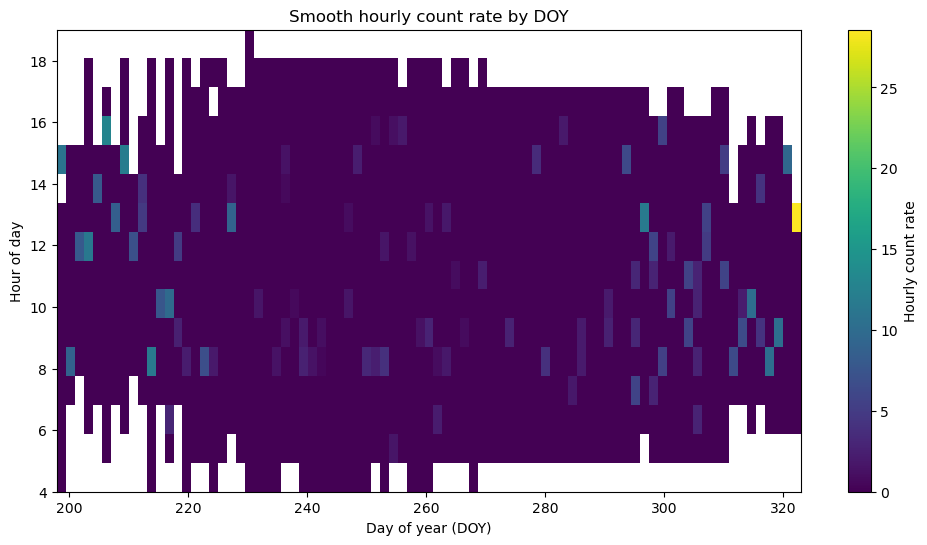

In [324]:
df_ratio = cd.get_ratio_species(species_name="Osprey")

# 5. Compute median ratio per DOY×hour
ratio_by_doy_hour = (
    df_ratio.groupby(["doy", "hour"])["ratio_valid"]
    .agg(ratio="median", n_obs="count")
    .reset_index()
)

pivot = ratio_by_doy_hour.pivot(
    index="hour", columns="doy", values="ratio"
)  # .fillna(0)

plt.figure(figsize=(12, 6))
im = plt.imshow(
    pivot,
    aspect="auto",
    origin="lower",
    extent=[
        pivot.columns.min(),
        pivot.columns.max(),
        pivot.index.min(),
        pivot.index.max(),
    ],
)

plt.colorbar(im, label="Hourly count rate")
plt.ylabel("Hour of day")
plt.xlabel("Day of year (DOY)")
plt.title("Smooth hourly count rate by DOY")
plt.show()

In [325]:
# Fit robust GAM
df_ratio = cd.get_ratio_species(species_name="European Honey-buzzard")
X = df_ratio[["doy", "hour"]].values
y = df_ratio["ratio_valid"].values

doy_splines = [4, 6, 8]
hour_splines = [4, 10, 16]
best_score = np.inf
best_model = None

for k0, k1 in product(doy_splines, hour_splines):
    gam = PoissonGAM(
        s(0, n_splines=k0) + s(1, n_splines=k1) + te(0, 1, n_splines=[k0, k1])
    ).fit(X, y)
    score = gam.statistics_.get("AIC")
    if score is not None and score < best_score:
        best_score = score
        best_model = gam
        print(f"k0={k0}, k1={k1}, AIC={score:.4f}")

print("Best GAM:", best_model)

k0=4, k1=4, AIC=16565.1434
k0=4, k1=10, AIC=16206.3966
k0=4, k1=10, AIC=16206.3966
k0=4, k1=16, AIC=16201.3202
k0=4, k1=16, AIC=16201.3202


OptimizationError: PIRLS optimization has diverged.
Try increasing regularization, or specifying an initial value for self.coef_

In [339]:
np.array(Z).T.tolist()

[[0.2046806901319028,
  0.5875644016424357,
  1.1232587883205056,
  1.4030701878068632,
  1.295250838003592,
  1.1464252650831852,
  1.1348539048838886,
  1.1757529158202717,
  1.1400541450462256,
  0.9289622473604092,
  0.62204412841341,
  0.35060343289299856],
 [0.20488738803757506,
  0.5881577567419753,
  1.1243931173034896,
  1.4044870858500733,
  1.2965588540912991,
  1.1475829888584457,
  1.1359999432582575,
  1.1769402562827815,
  1.1412054349113425,
  0.929900364927114,
  0.6226723030521407,
  0.3509574916723283],
 [0.20509429467824902,
  0.5887517110443822,
  1.1255285917947528,
  1.405905414755462,
  1.297868191086151,
  1.1487418817673434,
  1.137147138965698,
  1.178128795787501,
  1.1423578874127778,
  0.9308394298569345,
  0.6233011120564393,
  0.35131190799983786],
 [0.20530141026471693,
  0.5893462651547645,
  1.126665212951093,
  1.4073251759679923,
  1.299178850322072,
  1.1499019449905339,
  1.1382954931749492,
  1.1793185355452893,
  1.143511503724625,
  0.931779443

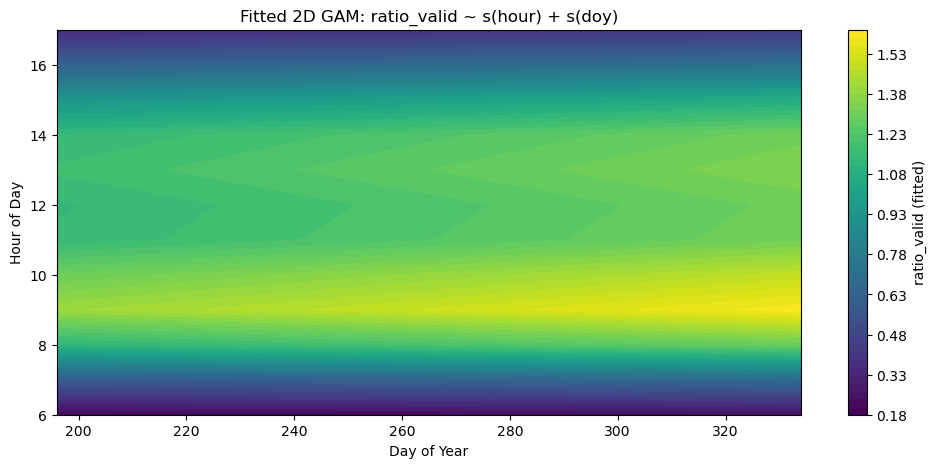

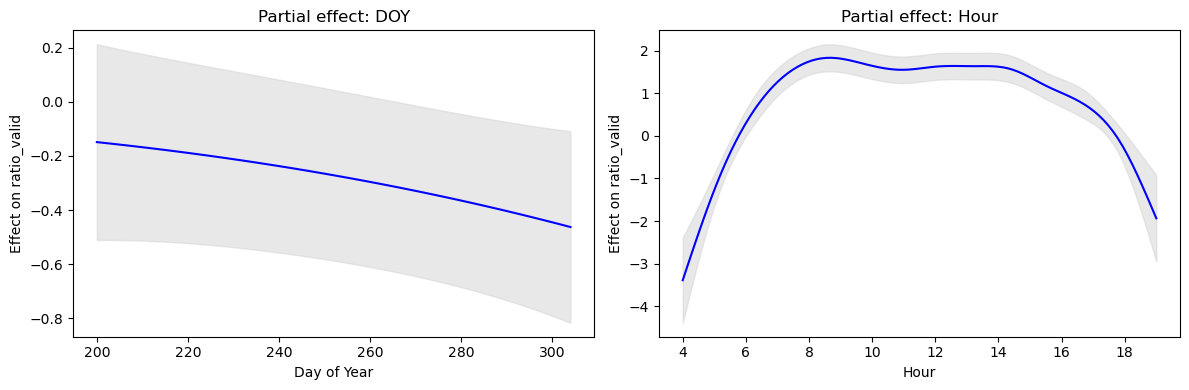

In [337]:
df_ratio = cd.get_ratio_species(species_name="European Honey-buzzard")

Z = cd.fit_ratio_species(df_ratio)  # , k0=5, k1=10)

doy_grid = np.arange(cd.doy[0], cd.doy[1])
hour_grid = np.arange(6, 18)
XX, YY = np.meshgrid(doy_grid, hour_grid)


# Plot heatmap / contour
plt.figure(figsize=(12, 5))
plt.contourf(XX, YY, Z, levels=50, cmap="viridis")
plt.colorbar(label="ratio_valid (fitted)")
plt.xlabel("Day of Year")
plt.ylabel("Hour of Day")
plt.title("Fitted 2D GAM: ratio_valid ~ s(hour) + s(doy)")
plt.show()

plt.figure(figsize=(12, 4))

# 1. Partial effect of DOY
plt.subplot(1, 2, 1)
XX = gam.generate_X_grid(term=0)
pdep, conf = gam.partial_dependence(
    term=0, X=XX, width=0.95
)  # pdep = mean, conf = (n_points,2)
plt.plot(XX[:, 0], pdep, color="blue")
plt.fill_between(XX[:, 0], conf[:, 0], conf[:, 1], color="lightgray", alpha=0.5)
plt.xlabel("Day of Year")
plt.ylabel("Effect on ratio_valid")
plt.title("Partial effect: DOY")

# 2. Partial effect of Hour
plt.subplot(1, 2, 2)
XX = gam.generate_X_grid(term=1)
pdep, conf = gam.partial_dependence(term=1, X=XX, width=0.95)
plt.plot(XX[:, 1], pdep, color="blue")
plt.fill_between(XX[:, 1], conf[:, 0], conf[:, 1], color="lightgray", alpha=0.5)
plt.xlabel("Hour")
plt.ylabel("Effect on ratio_valid")
plt.title("Partial effect: Hour")

plt.tight_layout()
plt.show()

In [340]:
all_stats = cd.export_species_statistics()

Using default species list: 11 species: ['Common Buzzard', 'Red Kite', 'Black Kite', 'European Honey-buzzard', 'Western Marsh Harrier', 'Eurasian Sparrowhawk', 'Eurasian Kestrel', 'Osprey', 'Hen Harrier', 'Merlin', 'Eurasian Hobby']


In [331]:
all_stats[0]["trektellen_species_id"]

101

In [279]:
def plot_doy(all_stats):

    fig, axes = plt.subplots(
        nrows=len(all_stats),
        ncols=1,
        figsize=(10, 3 * len(all_stats)),
        sharex=True,
    )
    if len(all_stats) == 1:
        axes = [axes]

    for ax, data in zip(axes, all_stats):
        ax.plot(data["doy"], data["median"], label="Median", color="black")
        ax.fill_between(
            data["doy"],
            data["q25"],
            data["q75"],
            color="gray",
            alpha=0.3,
            label="25-75% Quantile",
        )
        ax.plot(data["doy"], data["mean"], label="Mean", color="black", linestyle="--")
        # ax.plot(data["doy"], data["max"], label="Max", color="red")
        total_obs = sum(data["count_observations"])
        ax.set_title(f"{data['species']} (n={total_obs})")
        ax.set_ylabel("Count Rate")
        ax.legend(loc="upper right")

    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
    plt.show()


plot_doy(all_stats)

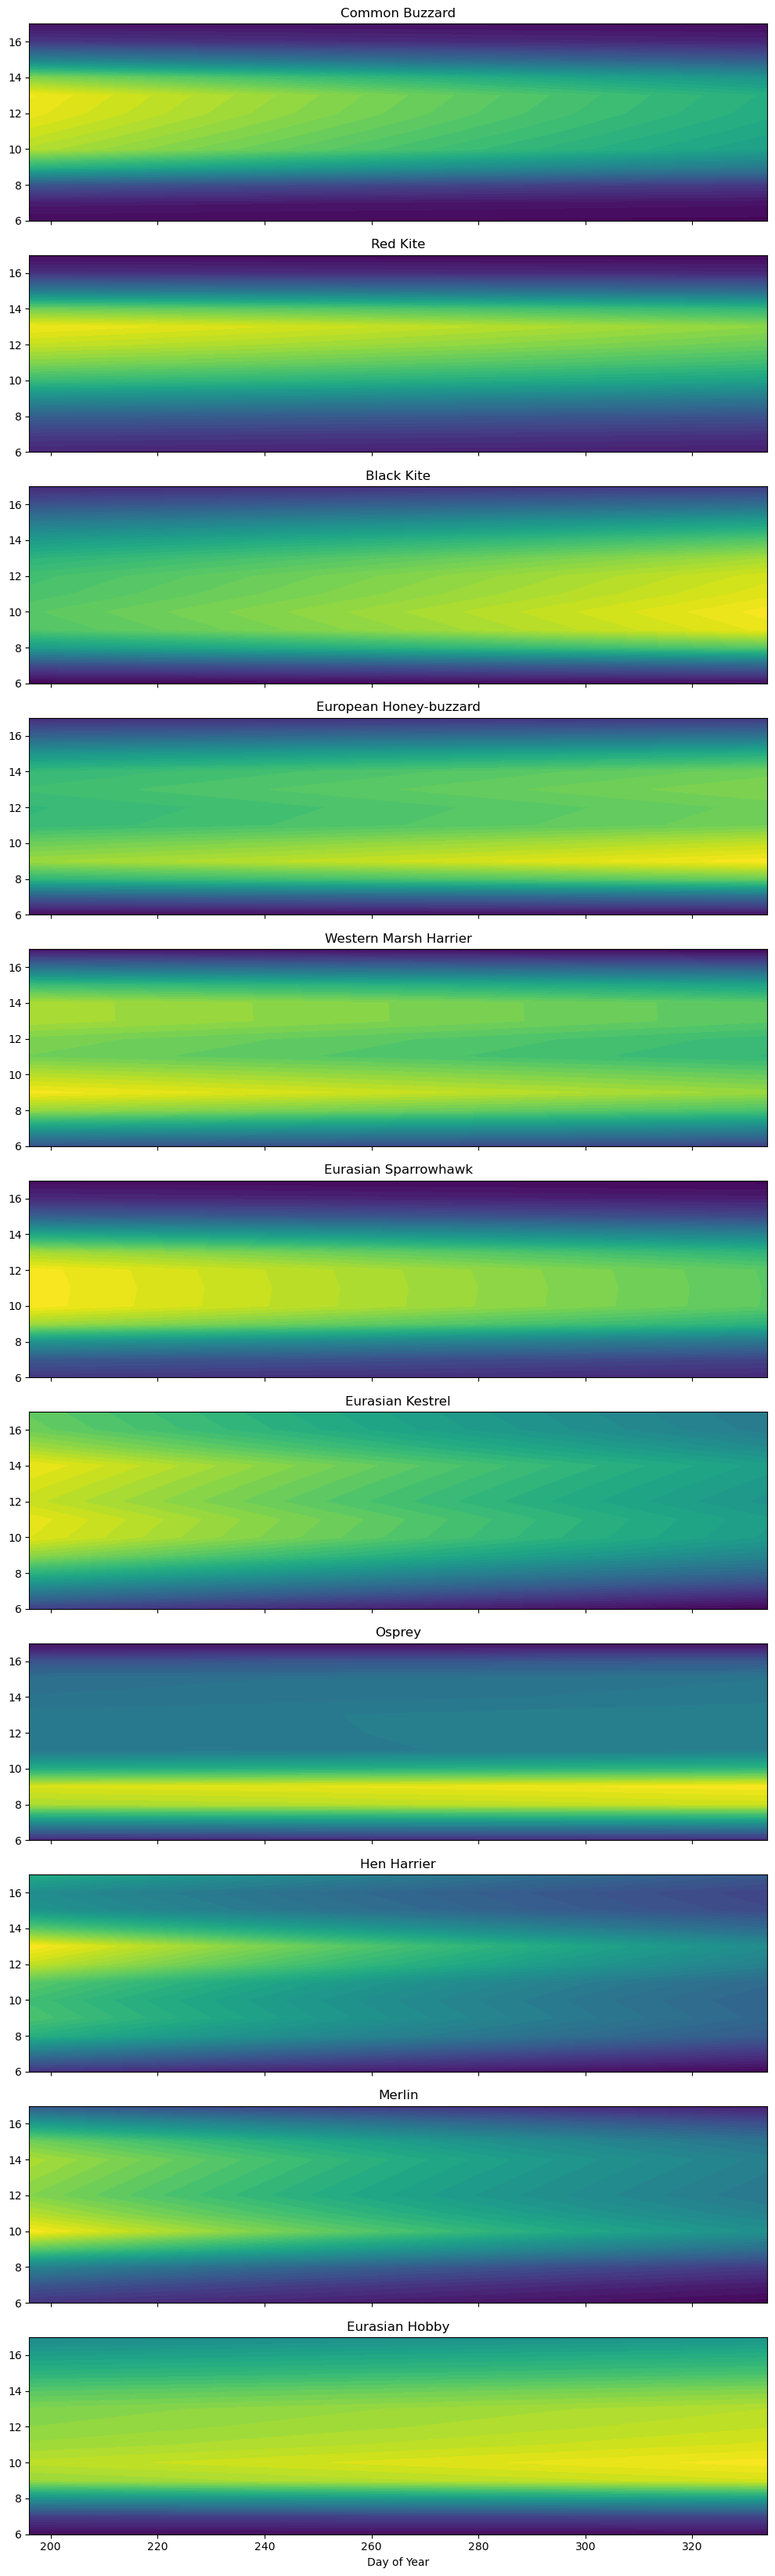

In [341]:
def plot_ratio(all_stats):

    doy_grid = np.arange(cd.doy[0], cd.doy[1])
    hour_grid = np.arange(6, 18)
    XX, YY = np.meshgrid(doy_grid, hour_grid)

    fig, axes = plt.subplots(
        nrows=len(all_stats),
        ncols=1,
        figsize=(10, 3 * len(all_stats)),
        sharex=True,
    )
    if len(all_stats) == 1:
        axes = [axes]

    for ax, data in zip(axes, all_stats):

        Z = np.array(data["ratio"]).T  # transpose back to hour x DOY for plotting
        ax.contourf(XX, YY, Z, levels=50, cmap="viridis")
        # ax.plot(data["doy"], data["max"], label="Max", color="red")

        ax.set_title(f"{data['species']}")

    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
    plt.show()


plot_ratio(all_stats)

In [343]:
# Save to JSON file
import json

with open("../data/count/species_doy_statistics.json", "w") as f:
    json.dump(all_stats, f, indent=2)

print(f"Exported statistics for {len(all_stats)} species. ")

Exported statistics for 11 species. 
